In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D,Dropout,Flatten,Dense,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np


In [48]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 60
BS = 20

In [ ]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [ ]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [37]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])


[INFO] compiling model...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# construct the training image generator for data augmentation
train_datagen = ImageDataGenerator(
	rescale = 1./255,
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")
test_datagen = ImageDataGenerator(rescale = 1./255)

In [17]:
train_path = '/content/drive/MyDrive/Colab Notebooks/cell_images/train'
test_path = '/content/drive/MyDrive/Colab Notebooks/cell_images/test'

In [23]:
training_set = train_datagen.flow_from_directory(
	train_path,
	target_size=(224, 224),
	batch_size = BS,
	class_mode = 'categorical'
	)


Found 2000 images belonging to 2 classes.


In [24]:
test_set = train_datagen.flow_from_directory(
	test_path,
	target_size=(224, 224),
	batch_size = BS,
	class_mode = 'categorical'
	)


Found 500 images belonging to 2 classes.


In [42]:
from keras.callbacks import ModelCheckpoint

In [45]:
filepath = '/content/drive/MyDrive/Colab Notebooks/malaria/my_best_malaria_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

In [47]:
callbacks = [checkpoint]

In [49]:
# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(training_set,
	steps_per_epoch=len(training_set) // BS,
	validation_data=test_set,
	validation_steps=len(test_set) // BS ,
	epochs=EPOCHS,
  callbacks=callbacks)


[INFO] training head...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/60
5/5 [==============================] - ETA: 0s - loss: 0.2206 - accuracy: 0.9200
Epoch 00001: val_loss improved from inf to 0.18553, saving model to /content/drive/MyDrive/Colab Notebooks/malaria/my_best_malaria_model.epoch01-loss0.19.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


5/5 [==============================] - 7s 1s/step - loss: 0.2206 - accuracy: 0.9200 - val_loss: 0.1855 - val_accuracy: 1.0000
Epoch 2/60
5/5 [==============================] - ETA: 0s - loss: 0.2264 - accuracy: 0.9300
Epoch 00002: val_loss improved from 0.18553 to 0.16278, saving model to /content/drive/MyDrive/Colab Notebooks/malaria/my_best_malaria_model.epoch02-loss0.16.hdf5
5/5 [==============================] - 6s 1s/step - loss: 0.2264 - accuracy: 0.9300 - val_loss: 0.1628 - val_accuracy: 0.9500
Epoch 3/60
5/5 [==============================] - ETA: 0s - loss: 0.2372 - accuracy: 0.9300
Epoch 00003: val_loss did not improve from 0.16278
5/5 [==============================] - 6s 1s/step - loss: 0.2372 - accuracy: 0.9300 - val_loss: 0.3465 - val_accuracy: 0.9500
Epoch 4/60
5/5 [==============================] - ETA: 0s - loss: 0.2887 - accuracy: 0.9100
Epoch 00004: val_loss improved from 0.16278 to 0.11099, saving model to /content/drive/MyDrive/Colab Notebooks/malaria/my_best_malar

In [51]:
from keras.models import load_model

In [54]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/malaria/my_best_malaria_model.epoch28-loss0.07.hdf5')
pred = model.predict(test_set)

In [57]:
# make predictions on the testing set
print("[INFO] evaluating network...")
model.evaluate(test_set,batch_size= BS)

[INFO] evaluating network...
25/25 [==============================] - 22s 848ms/step - loss: 0.2165 - accuracy: 0.9340


[0.2164783477783203, 0.9340000152587891]

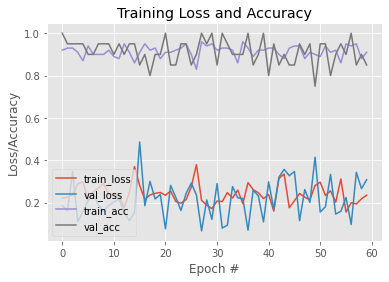

In [58]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")